In [ ]:
pip install tensorflow-addons

     |████████████████████████████████| 686kB 30.9MB/s 


In [ ]:
from PIL import Image, ImageDraw, ImageFont
import numpy as np
import matplotlib.pyplot as plt
import random
import string
import math
import os
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, Reshape
from tensorflow.keras.layers import Dense, concatenate, Input, Layer, GlobalMaxPooling2D, Lambda
from tensorflow.keras.layers import Add, LeakyReLU, Concatenate, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG19
from tensorflow.image import psnr
from tensorflow.image import ssim
import tensorflow_addons as tfa
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [ ]:
SIZE = 10000
def get_batch(num=0):
    X = []
    y = []
    for i in range(SIZE):
        img = Image.new("RGB", (256, 256), (255, 255, 255))
        draw = ImageDraw.Draw(img)
        size = np.random.randint(10, 31, 1)[0]
        font = ImageFont.truetype('FreeSans.ttf', size)
        text = ""
        for _ in range(6):
            text += ''.join(random.choice(string.ascii_letters + string.digits) for _ in range(10))
            text += '\n'
        left = np.random.randint(0, 255, 1)[0] # 50
        draw.text((left, left), text, font=font, align ="left", fill='black')

        qual = int(random.uniform(1, 100))
        img.save("tmp.jpg", "JPEG", quality=qual, subsampling=1)
        img_com = Image.open("tmp.jpg")

        arr = np.array(img_com, dtype=np.uint8)
        X.append(arr)
        arr = np.array(img, dtype=np.uint8)
        y.append(arr)

    X = np.array(X)
    y = np.array(y)
    return X, y

X, y = get_batch()

In [ ]:
neurons_num = 16
in_l = Input((256,256,3,))
x1 = layers.experimental.preprocessing.Rescaling(1./255)(in_l)
x = Conv2D(neurons_num, (3,3), activation='relu', padding="same")(x1)
x = Conv2D(neurons_num, (3,3), activation='relu', padding="same")(x)
x1 = concatenate([x, x1])
x = Conv2D(neurons_num, (3,3), activation='relu', padding="same")(x1)
x = Conv2D(neurons_num, (3,3), activation='relu', padding="same")(x)
x1 = concatenate([x, x1])
x = Conv2D(neurons_num, (3,3), activation='relu', padding="same")(x1)
x = Conv2D(neurons_num, (3,3), activation='relu', padding="same")(x)
x1 = concatenate([x, x1])
x = Conv2D(neurons_num, (3,3), activation='relu', padding="same")(x1)
x = Conv2D(neurons_num, (3,3), activation='relu', padding="same")(x)
x1 = concatenate([x, x1])
x = Conv2D(3, (1,1), activation='sigmoid', padding="same")(x1)
x = layers.experimental.preprocessing.Rescaling(255)(x)

model = Model(in_l, x)

In [ ]:
model.compile(optimizer=Adam(5e-4), loss="mae")
history = model.fit(X, y, epochs=20, verbose=1, validation_split=0.2, batch_size=16)

Epoch 1/20
500/500 [==============================] - 114s 161ms/step - loss: 18.3149 - val_loss: 0.9274
Epoch 2/20
500/500 [==============================] - 85s 169ms/step - loss: 0.8061 - val_loss: 0.6794
Epoch 3/20
500/500 [==============================] - 84s 169ms/step - loss: 0.6444 - val_loss: 0.6210
Epoch 4/20
500/500 [==============================] - 84s 169ms/step - loss: 0.5837 - val_loss: 0.5692
Epoch 5/20
500/500 [==============================] - 83s 166ms/step - loss: 0.5477 - val_loss: 0.5414
Epoch 6/20
500/500 [==============================] - 83s 166ms/step - loss: 0.5283 - val_loss: 0.5403
Epoch 7/20
500/500 [==============================] - 83s 166ms/step - loss: 0.5307 - val_loss: 0.5088
Epoch 8/20
500/500 [==============================] - 83s 166ms/step - loss: 0.4988 - val_loss: 0.5107
Epoch 9/20
500/500 [==============================] - 83s 166ms/step - loss: 0.4846 - val_loss: 0.4828
Epoch 10/20
500/500 [==============================] - 83s 166ms/step -

In [ ]:
model.save_weights("text.h5")

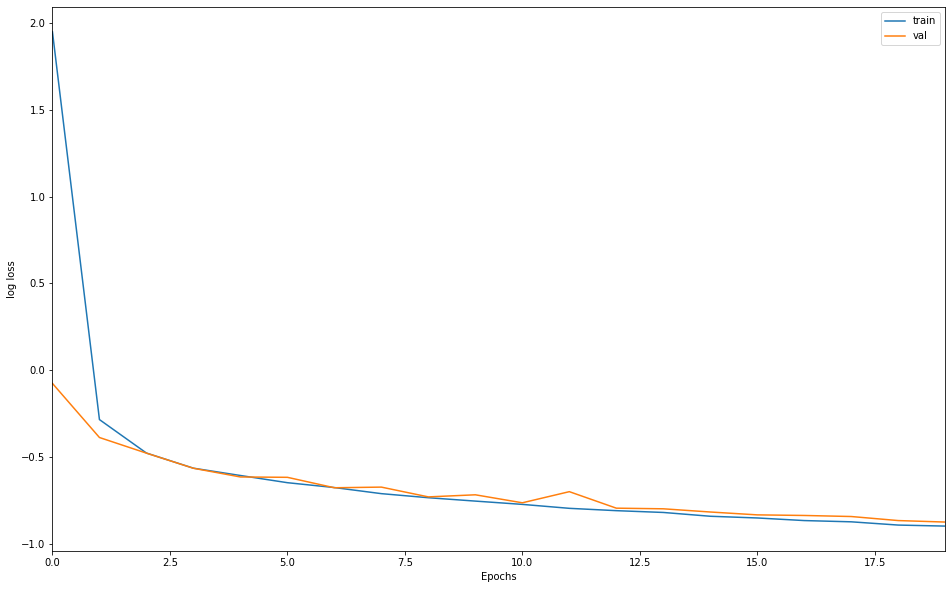

In [ ]:
def plot_history(history):
    plt.figure(figsize=(16,10))
    plt.xlabel('Epochs')
    plt.ylabel("log loss")
    plt.plot(history.epoch[:], np.log(history.history["loss"][:]), label='train')
    if "val_loss" in history.history.keys():
        plt.plot(history.epoch[:], np.log(history.history["val_loss"][:]), label='val')
    plt.xlim([0,max(history.epoch)])
    plt.legend()
    plt.show()

plot_history(history)

tf.Tensor(25.913433, shape=(), dtype=float32)
tf.Tensor(32.14821, shape=(), dtype=float32)
tf.Tensor(0.97002155, shape=(), dtype=float32)
tf.Tensor(0.99704033, shape=(), dtype=float32)


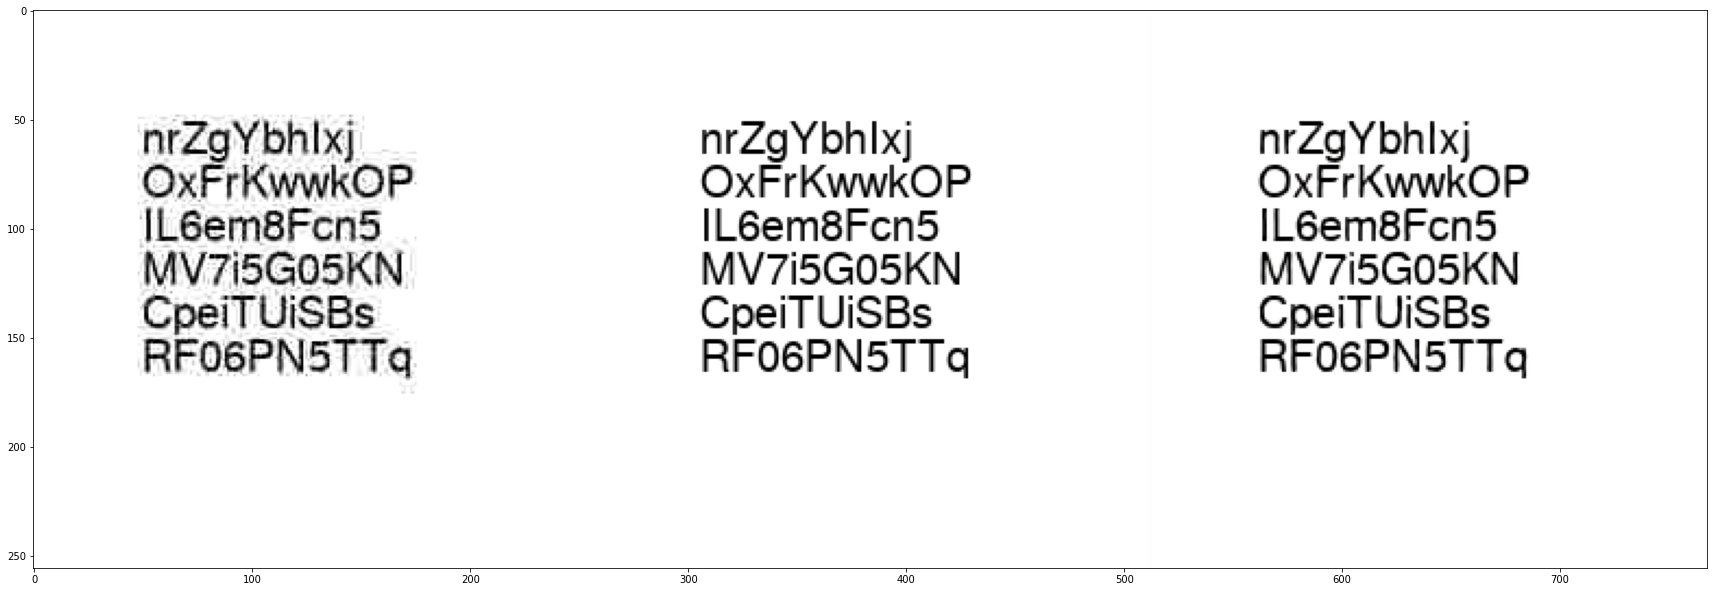

In [ ]:
def test_text(model):
    img = Image.new("RGB", (256, 256), (255, 255, 255))
    draw = ImageDraw.Draw(img)
    font = ImageFont.truetype('FreeSans.ttf', 20)
    text = ""
    for _ in range(6):
        text += ''.join(random.choice(string.ascii_letters + string.digits) for _ in range(10))
        text += '\n'
    draw.text((50, 50), text, font=font, align ="left", fill='black')

    img.save("tmp.jpg", "JPEG", quality=10, subsampling=1)
    img_com = Image.open("tmp.jpg")

    x_test = np.array(img_com, dtype=np.uint8)
    y_test = np.array(img, dtype=np.uint8)

    pred = model.predict(np.expand_dims(x_test, 0))[0].astype(np.uint8)
    plt.figure(figsize=(30,20))
    plt.imshow(np.concatenate([x_test, y_test, pred], axis=1))
    print(psnr(x_test, y_test, 255))
    print(psnr(pred, y_test, 255))
    print(ssim(x_test, y_test, 255))
    print(ssim(pred, y_test, 255))

test_text(model)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q "drive/MyDrive/Colab Notebooks/jpeg.zip"

In [ ]:
num = 0
data = []
for file in os.listdir("jpeg"):
    im = Image.open("jpeg/"+file)
    im = im.resize((512, 512)).convert('RGB')
    data.append(np.array(im, dtype=np.uint8))

data = np.array(data)
data, y_test = train_test_split(data, test_size=0.05)
X_test = tf.map_fn(lambda img: tf.image.adjust_jpeg_quality(img, 10), y_test).numpy()

In [ ]:
def unet(input_layer, start_neurons):
    conv1 = Conv2D(start_neurons*1,(3,3),activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons*1,(3,3),activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(start_neurons*2,(3,3),activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons*2,(3,3),activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(start_neurons*4,(3,3),activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons*4,(3,3),activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(start_neurons*8,(3,3),activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons*8,(3,3),activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # # Middle
    convm = Conv2D(start_neurons*16,(3,3),activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons*16,(3,3),activation="relu", padding="same")(convm)

    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons*8,(3,3),activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons*8,(3,3),activation="relu", padding="same")(uconv4)

    deconv3 = Conv2DTranspose(start_neurons*4,(3,3),strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons*4,(3,3),activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons*4,(3,3),activation="relu", padding="same")(uconv3)

    deconv2 = Conv2DTranspose(start_neurons*2,(3,3),strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons*2,(3,3),activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons*2,(3,3),activation="relu", padding="same")(uconv2)

    deconv1 = Conv2DTranspose(start_neurons*1,(3,3),strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons*1,(3,3),activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons*1,(3,3),activation="relu", padding="same")(uconv1)

    uncov1 = Dropout(0.5)(uconv1)
    output_layer = Conv2D(3,(1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer


in_l = Input((512, 512, 3,))
x = layers.experimental.preprocessing.Rescaling(1./255)(in_l)
x = in_l
x = unet(x, 32)
x = layers.experimental.preprocessing.Rescaling(255)(x)
model = Model(in_l, x)

In [ ]:
model.save_weights("documents.h5")

In [ ]:
def augmentation(X):
    qual = int(random.uniform(1, 50))

    X = tf.image.resize(X, (512,512))
    X = tf.cast(X, tf.uint8)
    y = tf.identity(X)

    X = tf.map_fn(lambda img: tf.image.adjust_jpeg_quality(img, qual), X)

    return X, y

In [ ]:
model.compile(optimizer=Adam(5e-4), loss="mae")

X, y = augmentation(data[:2000])

history = model.fit(X, y, epochs=20, verbose=1, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/20
125/125 [==============================] - 227s 1s/step - loss: 41.5655 - val_loss: 16.5608
Epoch 2/20
125/125 [==============================] - 172s 1s/step - loss: 16.5171 - val_loss: 16.5607
Epoch 3/20
125/125 [==============================] - 172s 1s/step - loss: 16.2682 - val_loss: 16.5603
Epoch 4/20
125/125 [==============================] - 172s 1s/step - loss: 16.3198 - val_loss: 16.5547
Epoch 5/20
125/125 [==============================] - 173s 1s/step - loss: 15.5872 - val_loss: 12.3127
Epoch 6/20
125/125 [==============================] - 174s 1s/step - loss: 10.5779 - val_loss: 6.5092
Epoch 7/20
125/125 [==============================] - 175s 1s/step - loss: 6.3506 - val_loss: 6.0067
Epoch 8/20
125/125 [==============================] - 177s 1s/step - loss: 5.5532 - val_loss: 5.9808
Epoch 9/20
125/125 [==============================] - 177s 1s/step - loss: 5.2792 - val_loss: 5.8414
Epoch 10/20
125/125 [==============================] - 177s 1s/step - loss: 5.09

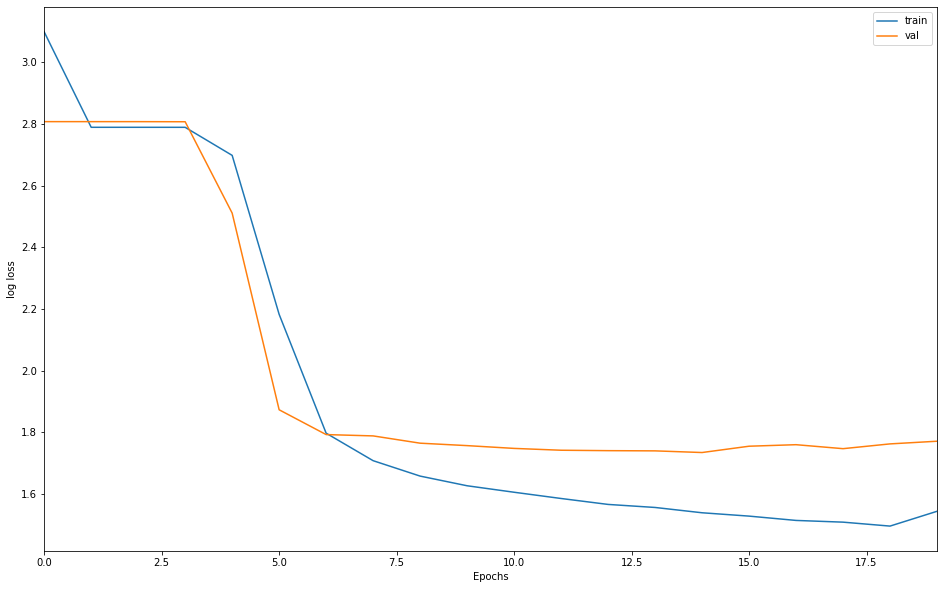

In [ ]:
def plot_history(history):
    plt.figure(figsize=(16,10))
    plt.xlabel('Epochs')
    plt.ylabel("log loss")
    plt.plot(history.epoch[:], np.log(history.history["loss"][:]), label='train')
    if "val_loss" in history.history.keys():
        plt.plot(history.epoch[:], np.log(history.history["val_loss"][:]), label='val')
    plt.xlim([0,max(history.epoch)])
    plt.legend()
    plt.show()

plot_history(history)

tf.Tensor(24.704899, shape=(), dtype=float32)
tf.Tensor(25.958311, shape=(), dtype=float32)
tf.Tensor(0.90156204, shape=(), dtype=float32)
tf.Tensor(0.96045107, shape=(), dtype=float32)


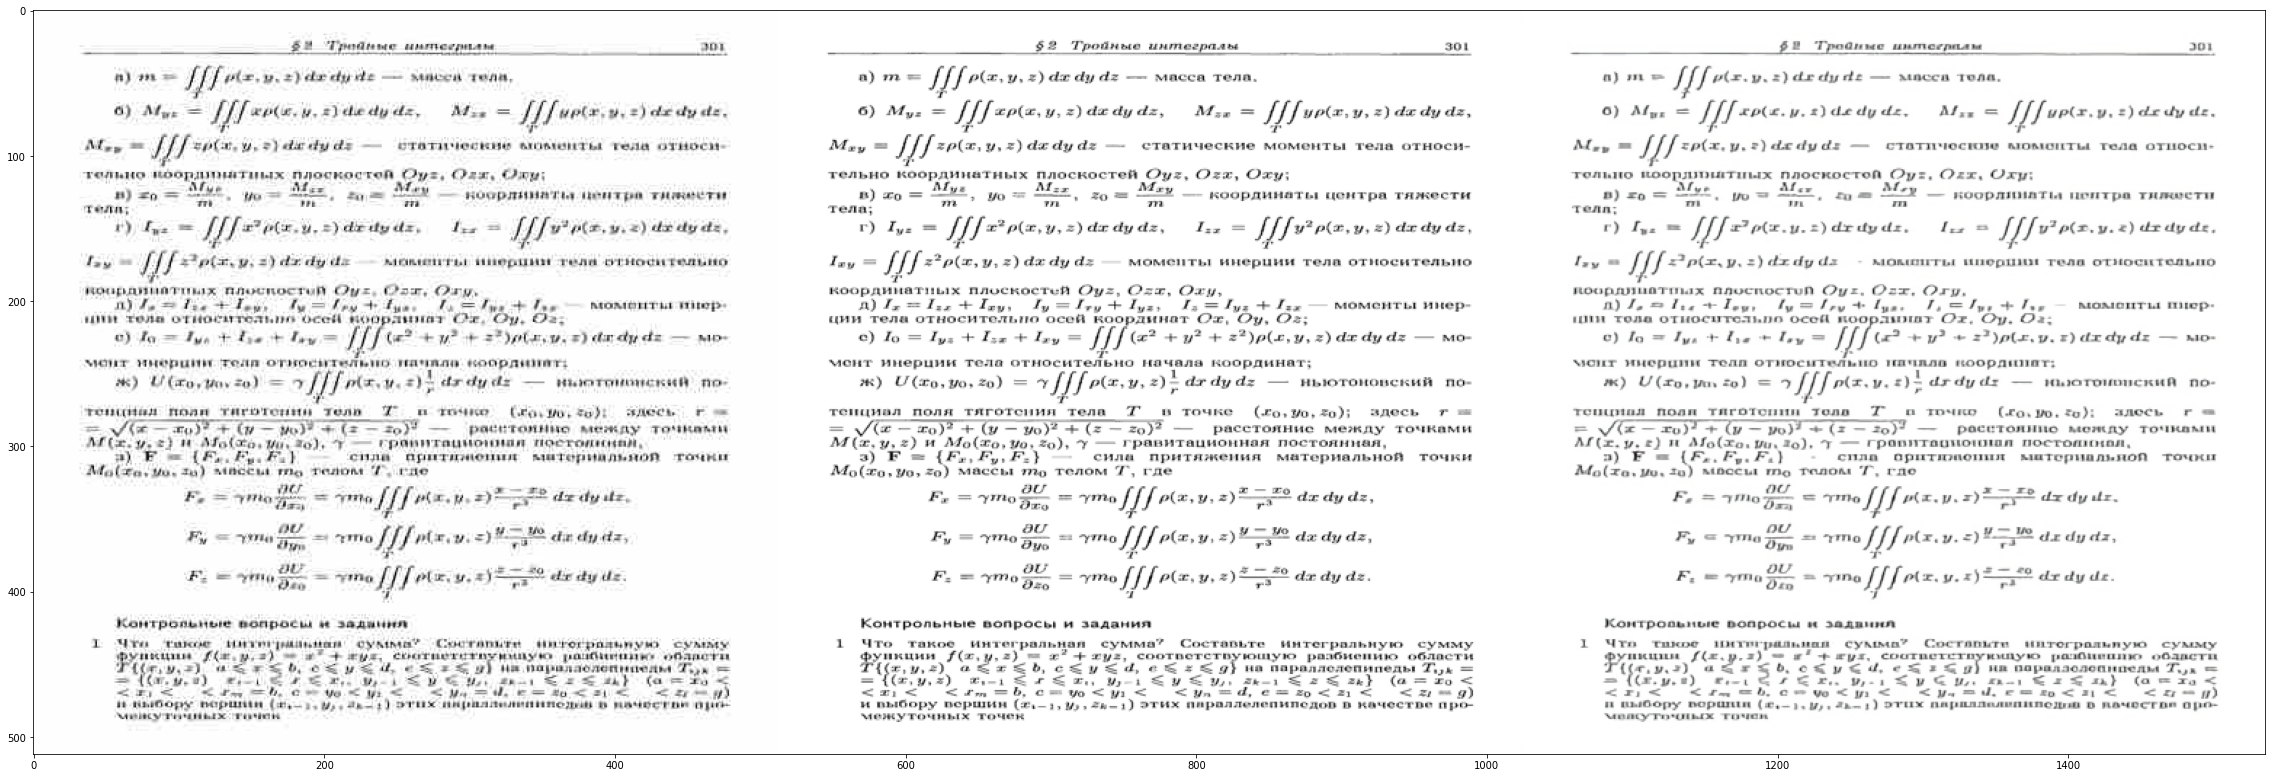

In [ ]:
def test(model):
    num = 1
    x_show = X[num]
    y_show = y[num]
    pred = model.predict(np.expand_dims(x_show, 0))[0].astype(np.uint8)
    plt.figure(figsize=(40,30))
    plt.imshow(np.concatenate([x_show, y_show, pred], axis=1))
    print(psnr(x_show, y_show, 255))
    print(psnr(pred, y_show, 255))
    print(ssim(x_show, y_show, 255))
    print(ssim(pred, y_show, 255))

test(model)

In [ ]:
import tensorflow_datasets as tfds
IMG_SIZE = 256

ds = tfds.load('plant_village', split='train', shuffle_files=False)

y_val = []
for ex in ds.take(128):
    y_val.append(tf.image.resize(ex['image'], (IMG_SIZE,IMG_SIZE)))
y_val = np.array(y_val, dtype=np.uint8)
x_val = tf.map_fn(lambda img: tf.image.adjust_jpeg_quality(img, 15), y_val)
y_val = tf.convert_to_tensor(y_val, tf.float32)/255.0
x_val = tf.cast(x_val, tf.float32)/255.0
ds = ds.skip(128)
ds = ds.repeat(100)

Shuffling and writing examples to /root/tensorflow_datasets/plant_village/1.0.2.incompleteDT69GZ/plant_village-train.tfrecord


Dataset plant_village downloaded and prepared to /root/tensorflow_datasets/plant_village/1.0.2. Subsequent calls will reuse this data.


In [ ]:
def augmentation(X):
    qual = int(random.uniform(1, 50))

    arr = []
    for ex in X:
        arr.append(ex['image'])
    X = np.array(arr)

    X = tf.image.resize(X, (IMG_SIZE,IMG_SIZE))
    X = tf.cast(X, tf.uint8)
    y = tf.identity(X)

    X = tf.map_fn(lambda img: tf.image.adjust_jpeg_quality(img, qual), X)

    X = tf.cast(X, tf.float32)/255.0
    y = tf.cast(y, tf.float32)/255.0

    return X, y

In [ ]:
BATCH_SIZE = 32 # 64
IMG_SIZE = 256

def unet(input_layer, start_neurons):
    conv1 = Conv2D(start_neurons*1,(3,3),activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons*1,(3,3),activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)
    # pool1 = BatchNormalization()(pool1)

    conv2 = Conv2D(start_neurons*2,(3,3),activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons*2,(3,3),activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(start_neurons*4,(3,3),activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons*4,(3,3),activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(start_neurons*8,(3,3),activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons*8,(3,3),activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # # Middle
    convm = Conv2D(start_neurons*16,(3,3),activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons*16,(3,3),activation="relu", padding="same")(convm)

    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons*8,(3,3),activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons*8,(3,3),activation="relu", padding="same")(uconv4)

    deconv3 = Conv2DTranspose(start_neurons*4,(3,3),strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons*4,(3,3),activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons*4,(3,3),activation="relu", padding="same")(uconv3)

    deconv2 = Conv2DTranspose(start_neurons*2,(3,3),strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons*2,(3,3),activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons*2,(3,3),activation="relu", padding="same")(uconv2)

    deconv1 = Conv2DTranspose(start_neurons*1,(3,3),strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons*1,(3,3),activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons*1,(3,3),activation="relu", padding="same")(uconv1)

    uncov1 = Dropout(0.5)(uconv1)
    output_layer = Conv2D(3,(1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

def create_discriminator(start_neurons):
    in_l = Input((IMG_SIZE, IMG_SIZE, 3,))
    conv1 = Conv2D(start_neurons*1,(3,3), padding="same")(in_l)
    conv1 = LeakyReLU(0.2)(conv1)
    conv1 = Conv2D(start_neurons*1,(3,3), padding="same")(conv1)
    conv1 = LeakyReLU(0.2)(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    # pool1 = BatchNormalization()(pool1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(start_neurons*2,(3,3), padding="same")(pool1)
    conv2 = LeakyReLU(0.2)(conv2)
    conv2 = Conv2D(start_neurons*2,(3,3), padding="same")(conv2)
    conv2 = LeakyReLU(0.2)(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)
    # pool2 = BatchNormalization()(pool2)

    conv3 = Conv2D(start_neurons*4,(3,3), padding="same")(pool2)
    conv3 = LeakyReLU(0.2)(conv3)
    conv3 = Conv2D(start_neurons*4,(3,3), padding="same")(conv3)
    conv3 = LeakyReLU(0.2)(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)
    # pool3 = BatchNormalization()(pool3)

    conv4 = Conv2D(start_neurons*8,(3,3), padding="same")(pool3)
    conv4 = LeakyReLU(0.2)(conv4)
    conv4 = Conv2D(start_neurons*8,(3,3), padding="same")(conv4)
    conv4 = LeakyReLU(0.2)(conv4)
    pool4 = GlobalMaxPooling2D()(conv4)
    pool4 = Dropout(0.5)(pool4)
    # pool4 = BatchNormalization()(pool4)

    # # Middle
    # convm = Conv2D(start_neurons*16,(3,3), padding="same")(pool4)
    # convm = Conv2D(start_neurons*16,(3,3), padding="same")(convm)
    convm = Dense(start_neurons*16)(pool4)
    convm = LeakyReLU(0.2)(convm)
    convm = Dense(start_neurons*16)(convm)
    convm = LeakyReLU(0.2)(convm)
    # convm = BatchNormalization()(convm)
    
    
    x = Dense(1, activation='sigmoid')(convm)

    return Model(in_l, x)
    

in_l = Input((IMG_SIZE, IMG_SIZE, 3,))
x = in_l
x = unet(x, 32)
model = Model(in_l, x)

discriminator = create_discriminator(32)

In [ ]:
def my_loss(y_true, y_pred):
    loss1 = tf.math.reduce_mean(tf.math.abs(tf.cast(y_true, tf.float32)-y_pred), axis=(1, 2, 3))
    dis_loss = tf.keras.losses.binary_crossentropy(discriminator(y_pred), np.ones(BATCH_SIZE))
    ssim_loss = (1-ssim(tf.cast(y_true, tf.float32)/255.0, y_pred/255.0, 1))/2
    return tf.cast(dis_loss, tf.float32)/255.0+loss1

In [ ]:
losses = {'dis_loss': [],
          'model_loss': [],
          'l1_loss': []}

In [ ]:
import time

#
# 0.042

def epoch():
    begin = time.process_time()
    for i in range(0, 20):
        # x_train, y_train = augmentation(X[i:i+BATCH_SIZE])
        global ds
        x_train, y_train = augmentation(ds.take(BATCH_SIZE))
        ds = ds.skip(BATCH_SIZE)
        discriminator.trainable = True
        dis_loss = discriminator.train_on_batch(y_train, np.ones(BATCH_SIZE))
        discriminator.train_on_batch(model.predict(x_train), np.zeros(BATCH_SIZE))
        discriminator.trainable = False
        model_loss = model.train_on_batch(x_train, y_train)
        if i==0:
            losses['dis_loss'].append(dis_loss)
            losses['model_loss'].append(model_loss)

        # train_model.train_on_batch([x_train, y_train], np.zeros(BATCH_SIZE))
    # y_val = X[11000:11500]

    l1_loss = tf.math.reduce_mean(tf.math.abs(tf.cast(y_val, tf.float32)-model.predict(x_val))).numpy()
    losses['l1_loss'].append(l1_loss)
    print(l1_loss)


discriminator.compile(optimizer=Adam(5e-4), loss='binary_crossentropy')
model.compile(optimizer=Adam(5e-4), loss=my_loss)

for i in range(20):
    epoch()

0.05710171
0.048850212
0.05269439
0.051240753
0.050127212
0.047141448
0.05117564
0.053004604
0.053415775
0.0497682
0.0516025
0.050279398
0.0504861
0.051687147
0.05577561
0.048612002
0.046465427
0.048066422
0.049557034
0.049602646


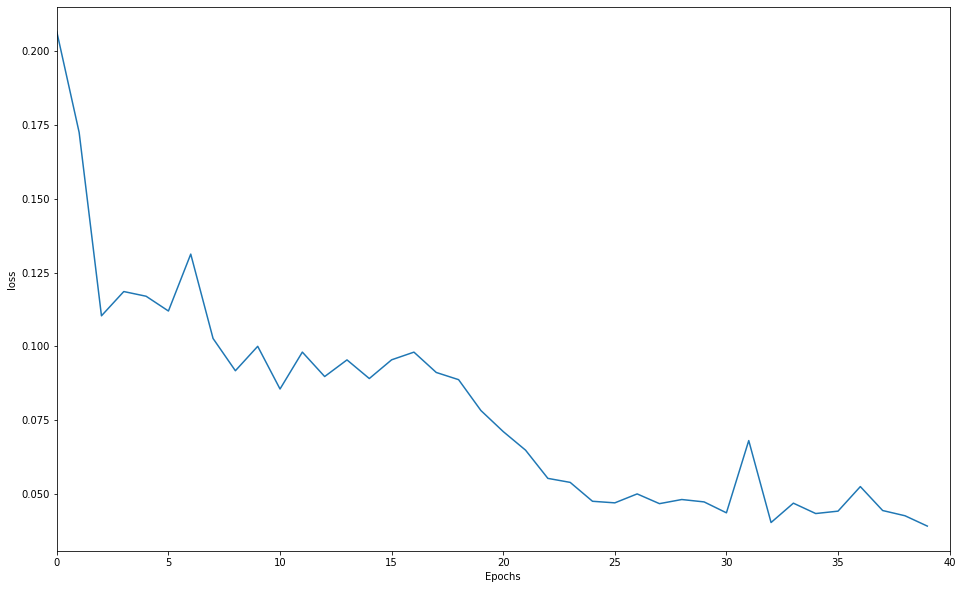

In [ ]:
def plot_loss(loss):
    plt.figure(figsize=(16,10))
    plt.xlabel('Epochs')
    plt.ylabel("loss")
    plt.plot(list(range(len(loss))), loss)
    plt.xlim([0,len(loss)])
    plt.show()

plot_loss(losses['model_loss'][:])
# model_loss
# l1_loss
# dis_loss

tf.Tensor(22.234241, shape=(), dtype=float32)
tf.Tensor(21.26619, shape=(), dtype=float32)
tf.Tensor(0.53017414, shape=(), dtype=float32)
tf.Tensor(0.49195656, shape=(), dtype=float32)


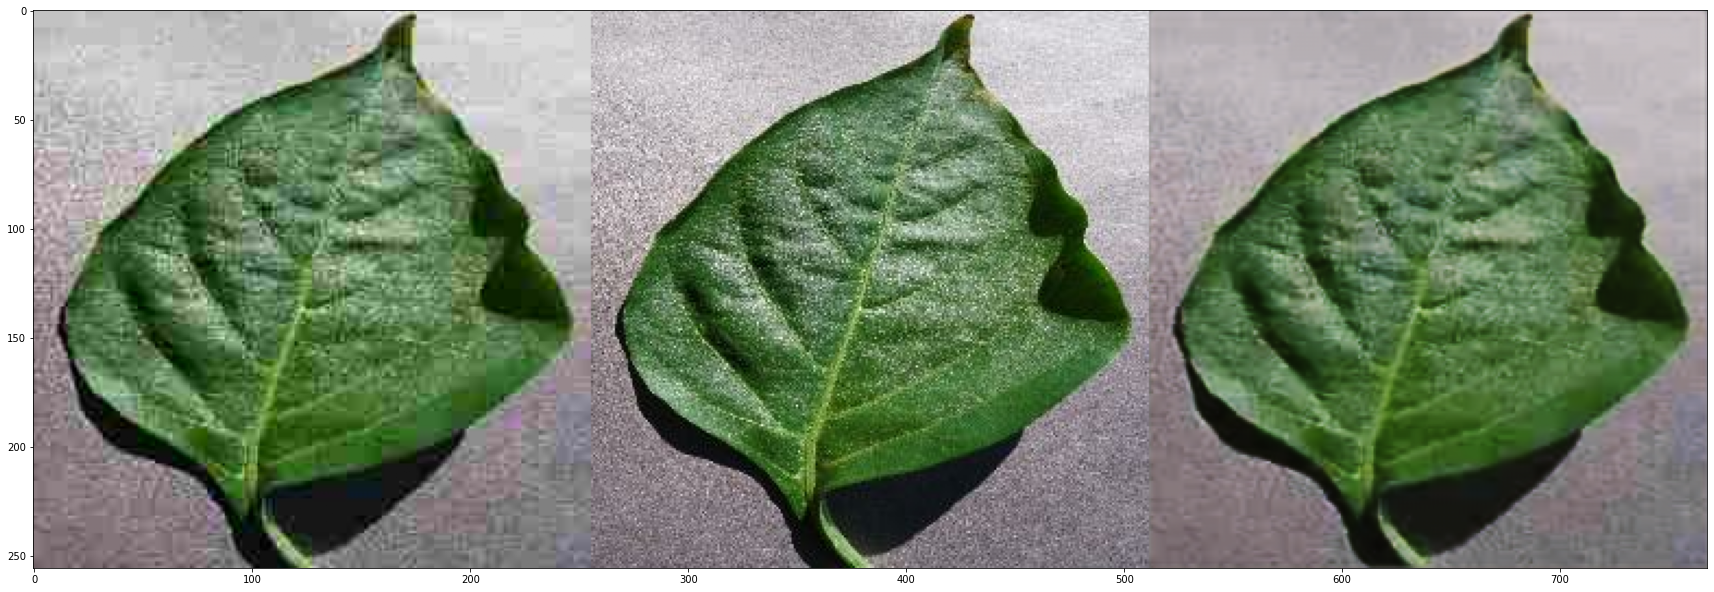

In [ ]:
def test(model):
    global ds
    num = 6 # 6
    # for ex in ds.take(1):
    #     y_test = tf.image.resize(ex['image'], (IMG_SIZE,IMG_SIZE))
    # y_test = tf.cast(y_test, tf.uint8)
    # ds = ds.skip(1)
    # x_test = tf.image.adjust_jpeg_quality(y_test, 20)
    pred = model.predict(np.expand_dims(x_val[num], 0))[0]
    plt.figure(figsize=(30,20))
    plt.imshow(np.concatenate([x_val[num], y_val[num], pred], axis=1))
    # plt.imshow(pred)
    print(psnr(x_val[num], y_val[num], 1))
    print(psnr(pred, y_val[num], 1))
    print(ssim(x_val[num], y_val[num], 1))
    print(ssim(pred, y_val[num], 1))

test(model)